In [131]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from  sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.model_selection import KFold, cross_val_score

In [92]:
file_path = "insurance_data.xlsx"
df = pd.read_excel(file_path)

Number of observations (rows)

In [93]:
df.shape[0]

1338

Number of attributes (columns)

In [94]:
df.shape[1]

8

Column names

In [95]:
list(df.columns)

['age',
 'gender',
 'bmi',
 'children',
 'smoker',
 'region',
 'NoClaimsBonus',
 'charges']

Missing values per column

In [96]:
df.isnull().sum().to_dict()

{'age': 0,
 'gender': 5,
 'bmi': 5,
 'children': 5,
 'smoker': 0,
 'region': 0,
 'NoClaimsBonus': 0,
 'charges': 7}

Total missing values

In [97]:
int(df.isnull().sum().sum())

22

Data types

In [98]:
df.dtypes.astype(str).to_dict()

{'age': 'int64',
 'gender': 'object',
 'bmi': 'float64',
 'children': 'float64',
 'smoker': 'object',
 'region': 'object',
 'NoClaimsBonus': 'float64',
 'charges': 'float64'}

In [99]:
df.head()

,age,gender,bmi,children,smoker,region,NoClaimsBonus,charges
0,19,female,27.900,0.0,yes,southwest,0.05,16884.92400
1,18,male,33.770,1.0,no,southeast,0.20,1725.55230
2,28,male,33.000,3.0,no,southeast,0.10,4449.46200
3,33,male,22.705,0.0,no,northwest,0.05,21984.47061
4,32,male,28.880,0.0,no,northwest,0.20,3866.85520


Data Cleaning

Handling missing values

In [100]:
df['gender'] = df['gender'].fillna(df['gender'].mode()[0])
df['bmi'] = df['bmi'].fillna(df['bmi'].median())
df['children'] = df['children'].fillna(df['children'].median())
df['charges'] = df['charges'].fillna(df['charges'].median())


In [101]:
int(df.isnull().sum().sum())

0

Correcting the data types

In [102]:
df['children'] = df['children'].astype(int)
df['NoClaimsBonus'] = df['NoClaimsBonus'].astype(int)

Distribution of charges

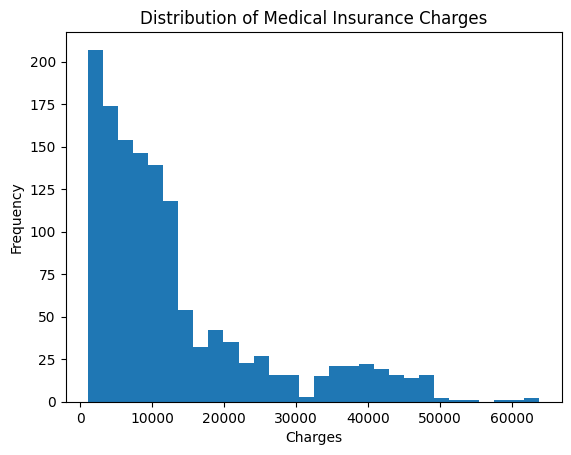

In [103]:
plt.figure()
plt.hist(df['charges'], bins=30)
plt.title("Distribution of Medical Insurance Charges")
plt.xlabel("Charges")
plt.ylabel("Frequency")
plt.show()

Impact of smoking on charges

<Figure size 640x480 with 0 Axes>

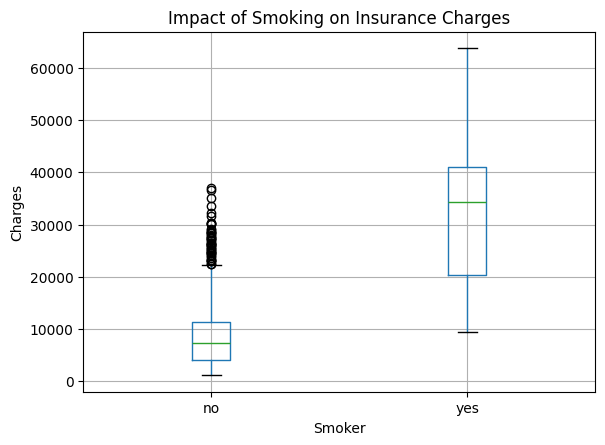

In [104]:
plt.figure()
df.boxplot(column='charges', by='smoker')
plt.title("Impact of Smoking on Insurance Charges")
plt.suptitle("")
plt.xlabel("Smoker")
plt.ylabel("Charges")
plt.show()

BMI vs Charges

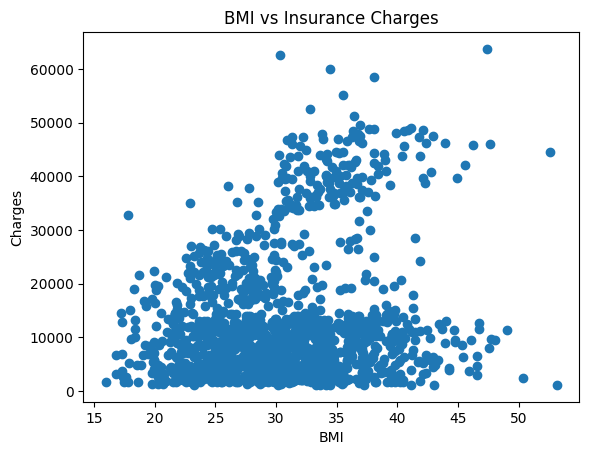

In [105]:
plt.figure()
plt.scatter(df['bmi'], df['charges'])
plt.title("BMI vs Insurance Charges")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.show()

Age vs Charges

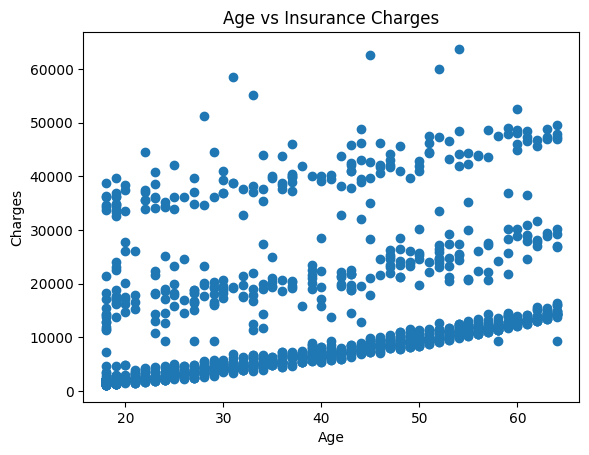

In [106]:
plt.figure()
plt.scatter(df['age'], df['charges'])
plt.title("Age vs Insurance Charges")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

 NoClaimsBonus vs Charges

<Figure size 640x480 with 0 Axes>

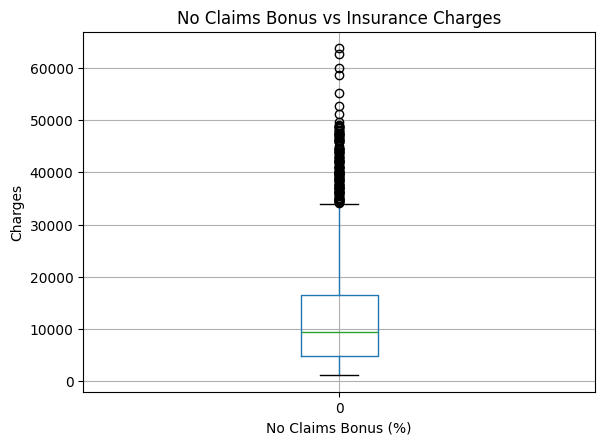

In [107]:
plt.figure()
df.boxplot(column='charges', by='NoClaimsBonus')
plt.title("No Claims Bonus vs Insurance Charges")
plt.suptitle("")
plt.xlabel("No Claims Bonus (%)")
plt.ylabel("Charges")
plt.show()

Regional comparison

<Figure size 640x480 with 0 Axes>

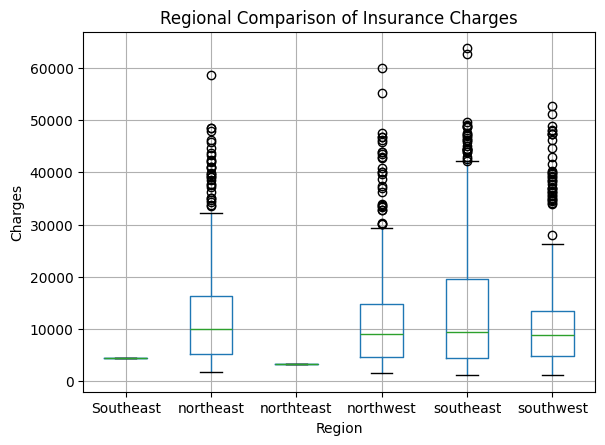

In [108]:
plt.figure()
df.boxplot(column='charges', by='region')
plt.title("Regional Comparison of Insurance Charges")
plt.suptitle("")
plt.xlabel("Region")
plt.ylabel("Charges")
plt.show()

Gender comparison

<Figure size 640x480 with 0 Axes>

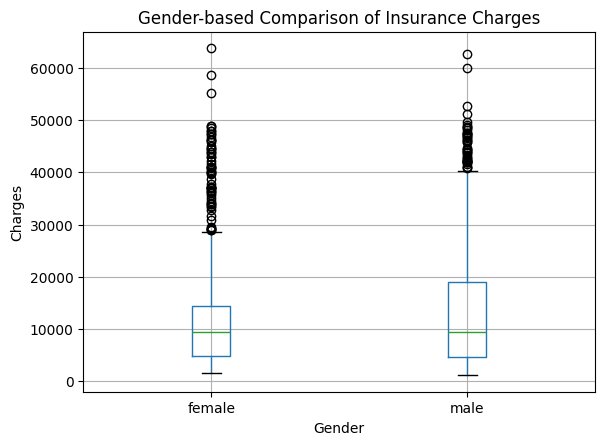

In [109]:
plt.figure()
df.boxplot(column='charges', by='gender')
plt.title("Gender-based Comparison of Insurance Charges")
plt.suptitle("")
plt.xlabel("Gender")
plt.ylabel("Charges")
plt.show()

Feature Engineering

BMI category because its easier for some models to capture non-linear risk bands

In [110]:
df['bmi_category'] = pd.cut(
    df['bmi'],
    bins=[0, 18.5, 25, 30, float("inf")],
    labels=['underweight', 'normal', 'overweight', 'obese'],
    right=False
)

In [111]:
df.head()

,age,gender,bmi,children,smoker,region,NoClaimsBonus,charges,bmi_category
0,19,female,27.900,0,yes,southwest,0,16884.92400,overweight
1,18,male,33.770,1,no,southeast,0,1725.55230,obese
2,28,male,33.000,3,no,southeast,0,4449.46200,obese
3,33,male,22.705,0,no,northwest,0,21984.47061,normal
4,32,male,28.880,0,no,northwest,0,3866.85520,overweight


Age multiply smoker interaction because its captures the idea that smoking risk often compounds with age

In [112]:
df['smoker_flag'] = (df['smoker'].str.lower() == 'yes').astype(int)
df['age_smoker_interaction'] = df['age'] * df['smoker_flag']

In [113]:
df.head()

,age,gender,bmi,children,smoker,region,NoClaimsBonus,charges,bmi_category,smoker_flag,age_smoker_interaction
0,19,female,27.900,0,yes,southwest,0,16884.92400,overweight,1,19
1,18,male,33.770,1,no,southeast,0,1725.55230,obese,0,0
2,28,male,33.000,3,no,southeast,0,4449.46200,obese,0,0
3,33,male,22.705,0,no,northwest,0,21984.47061,normal,0,0
4,32,male,28.880,0,no,northwest,0,3866.85520,overweight,0,0


Treat NoClaimsBonus as a categorical tier (since it has only 4 valid levels)

In [114]:
df['NoClaimsBonus_tier'] = df['NoClaimsBonus'].astype(str) + "%"

In [115]:
df.head()

,age,gender,bmi,children,smoker,region,NoClaimsBonus,charges,bmi_category,smoker_flag,age_smoker_interaction,NoClaimsBonus_tier
0,19,female,27.900,0,yes,southwest,0,16884.92400,overweight,1,19,0%
1,18,male,33.770,1,no,southeast,0,1725.55230,obese,0,0,0%
2,28,male,33.000,3,no,southeast,0,4449.46200,obese,0,0,0%
3,33,male,22.705,0,no,northwest,0,21984.47061,normal,0,0,0%
4,32,male,28.880,0,no,northwest,0,3866.85520,overweight,0,0,0%


Encode categorical variables manually

In [116]:
df_encoded = pd.get_dummies(
    df[['age','bmi','children','smoker_flag','age_smoker_interaction','region','gender']],
    drop_first=True
)

In [117]:
y = df["charges"]

numeric_cols = ["age", "bmi", "children", "NoClaimsBonus", "age_smoker_interaction"]
cat_cols = ["region", "gender", "smoker"]

X_num = df[numeric_cols].copy()
X_cat = df[cat_cols].copy()

In [118]:
X_num_train, X_num_test, X_cat_train, X_cat_test, y_train, y_test = train_test_split(
    X_num, X_cat, y, test_size=0.2, random_state=42
)

In [119]:
ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
X_cat_train_ohe = ohe.fit_transform(X_cat_train)
X_cat_test_ohe = ohe.transform(X_cat_test)

In [120]:
scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train)
X_num_test_scaled = scaler.transform(X_num_test)

Combine processed numeric and categorical features

In [121]:
X_train = np.hstack([X_num_train_scaled, X_cat_train_ohe])
X_test = np.hstack([X_num_test_scaled, X_cat_test_ohe])

In [122]:
ohe_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = numeric_cols + list(ohe_feature_names)

## Conceptual justification: supervised vs unsupervised (task choice)

This dataset contains a clearly defined target variable **charges** which represents a continuous numeric value (medical insurance cost). Because the outcome is known for historical records the most appropriate approach is **supervised learning** where the model learns a mapping from input features (age, BMI, smoker, etc.) to the target (charges).

### Prediction vs classification vs clustering
- **Prediction (Regression)** is the natural task because charges is continuous and we want to estimate its value for new customers.
- **Classification** would require converting charges into categories (e.g. low/medium/high) which reduces information and can introduce arbitrary thresholds.
- **Clustering** is unsupervised and can be used to group similar customers (segmentation) but it does not directly optimise the ability to predict charges.

Therefore, this work focuses on **supervised regression**. Unsupervised techniques may be useful as a secondary analysis but not as the primary solution when the goal is cost prediction.


Hyperparameter tuning with GridSearchCV

In [123]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    "n_estimators": [150, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

Evaluate on test set

In [124]:
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Best hyperparameters:", grid.best_params_)
print("Test R2:", r2)
print("Test RMSE:", rmse)

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Test R2: 0.8741856270057108
Test RMSE: 4419.561269039749


Feature selection using Random Forest feature importance

In [125]:
importances = best_model.feature_importances_
imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
imp_df = imp_df.sort_values("importance", ascending=False)

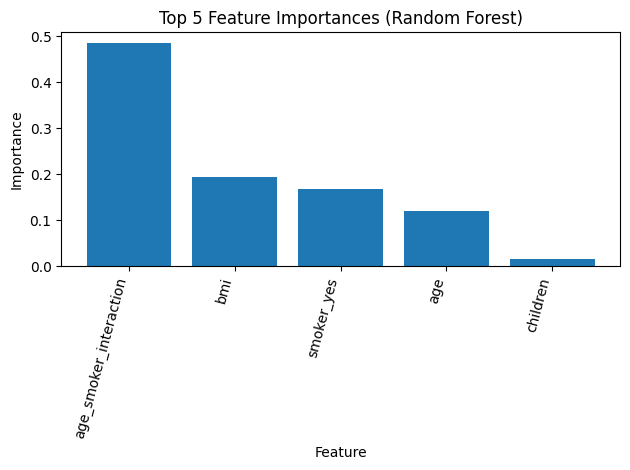

In [126]:
plt.figure()
plt.bar(imp_df.head(5)["feature"], imp_df.head(5)["importance"])
plt.title("Top 5 Feature Importances (Random Forest)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

Split 80/20

In [127]:
results = []

X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X, y, test_size=0.2, random_state=42)

lr_80 = LinearRegression()
lr_80.fit(X_train_80, y_train_80)
pred_lr_80 = lr_80.predict(X_test_20)
results.append({
    "Model": "Linear Regression",
    "Split": "80/20",
    "R2": r2_score(y_test_20, pred_lr_80),
    "RMSE": np.sqrt(mean_squared_error(y_test_20, pred_lr_80))
})

rf_80 = best_model
rf_80.fit(X_train_80, y_train_80)
pred_rf_80 = rf_80.predict(X_test_20)
results.append({
    "Model": "Random Forest (Tuned)",
    "Split": "80/20",
    "R2": r2_score(y_test_20, pred_rf_80),
    "RMSE": np.sqrt(mean_squared_error(y_test_20, pred_rf_80))
})

Split 70 / 30

In [128]:
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X, y, test_size=0.3, random_state=42)

lr_70 = LinearRegression()
lr_70.fit(X_train_70, y_train_70)
pred_lr_70 = lr_70.predict(X_test_30)
results.append({
    "Model": "Linear Regression",
    "Split": "70/30",
    "R2": r2_score(y_test_30, pred_lr_70),
    "RMSE": np.sqrt(mean_squared_error(y_test_30, pred_lr_70))
})

rf_70 = best_model
rf_70.fit(X_train_70, y_train_70)
pred_rf_70 = rf_70.predict(X_test_30)
results.append({
    "Model": "Random Forest (Tuned)",
    "Split": "70/30",
    "R2": r2_score(y_test_30, pred_rf_70),
    "RMSE": np.sqrt(mean_squared_error(y_test_30, pred_rf_70))
})

Split 60 / 40

In [129]:
X_train_60, X_test_40, y_train_60, y_test_40 = train_test_split(X, y, test_size=0.4, random_state=42)

lr_60 = LinearRegression()
lr_60.fit(X_train_60, y_train_60)
pred_lr_60 = lr_60.predict(X_test_40)
results.append({
    "Model": "Linear Regression",
    "Split": "60/40",
    "R2": r2_score(y_test_40, pred_lr_60),
    "RMSE": np.sqrt(mean_squared_error(y_test_40, pred_lr_60))
})

rf_60 = best_model
rf_60.fit(X_train_60, y_train_60)
pred_rf_60 = rf_60.predict(X_test_40)
results.append({
    "Model": "Random Forest (Tuned)",
    "Split": "60/40",
    "R2": r2_score(y_test_40, pred_rf_60),
    "RMSE": np.sqrt(mean_squared_error(y_test_40, pred_rf_60))
})

Results

In [130]:
split_results = pd.DataFrame(results)
print("\nTrain/Test results for 3 splits:")
print(split_results)


Train/Test results for 3 splits:
                   Model  Split        R2         RMSE
0      Linear Regression  80/20  0.782633  5809.126827
1  Random Forest (Tuned)  80/20  0.874124  4420.646028
2      Linear Regression  70/30  0.763005  5863.784089
3  Random Forest (Tuned)  70/30  0.851321  4644.432946
4      Linear Regression  60/40  0.752242  6038.455299
5  Random Forest (Tuned)  60/40  0.838199  4879.816655


K-Fold Cross-Validation

In [132]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lr_model = LinearRegression()
lr_cv_r2 = cross_val_score(lr_model, X, y, cv=kf, scoring="r2")
lr_cv_rmse = np.sqrt(-cross_val_score(lr_model, X, y, cv=kf, scoring="neg_mean_squared_error"))

rf_model = RandomForestRegressor(**grid.best_params_, random_state=42)
rf_cv_r2 = cross_val_score(rf_model, X, y, cv=kf, scoring="r2")
rf_cv_rmse = np.sqrt(-cross_val_score(rf_model, X, y, cv=kf, scoring="neg_mean_squared_error"))


Cross Validation Results

In [133]:
cv_results = pd.DataFrame([
    {
        "Model": "Linear Regression",
        "CV Mean R2": lr_cv_r2.mean(),
        "CV Std R2": lr_cv_r2.std(),
        "CV Mean RMSE": lr_cv_rmse.mean()
    },
    {
        "Model": "Random Forest (Tuned)",
        "CV Mean R2": rf_cv_r2.mean(),
        "CV Std R2": rf_cv_r2.std(),
        "CV Mean RMSE": rf_cv_rmse.mean()
    }
])

print("\nK-Fold Cross-Validation results:")
print(cv_results)


K-Fold Cross-Validation results:
                   Model  CV Mean R2  CV Std R2  CV Mean RMSE
0      Linear Regression    0.735830   0.057300   6109.588066
1  Random Forest (Tuned)    0.836295   0.039018   4801.415870


Comparison Tables

In [134]:
print("\nK-Fold Cross-Validation results:")
print(cv_results)
print("\nTrain/Test results for 3 splits:")
print(split_results)


K-Fold Cross-Validation results:
                   Model  CV Mean R2  CV Std R2  CV Mean RMSE
0      Linear Regression    0.735830   0.057300   6109.588066
1  Random Forest (Tuned)    0.836295   0.039018   4801.415870

Train/Test results for 3 splits:
                   Model  Split        R2         RMSE
0      Linear Regression  80/20  0.782633  5809.126827
1  Random Forest (Tuned)  80/20  0.874124  4420.646028
2      Linear Regression  70/30  0.763005  5863.784089
3  Random Forest (Tuned)  70/30  0.851321  4644.432946
4      Linear Regression  60/40  0.752242  6038.455299
5  Random Forest (Tuned)  60/40  0.838199  4879.816655


Comparison Graph

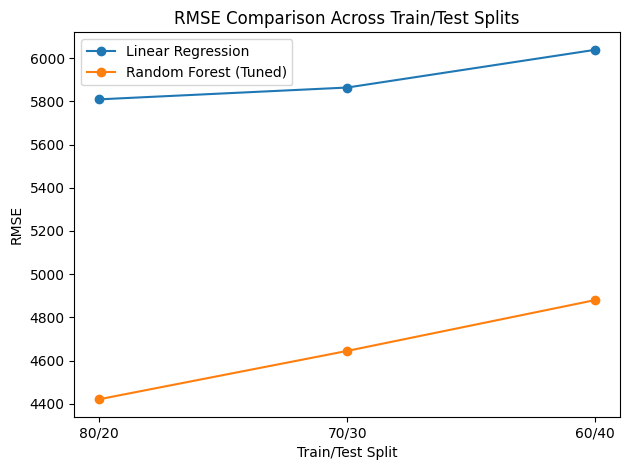

In [135]:
plt.figure()
for model_name in split_results["Model"].unique():
    subset = split_results[split_results["Model"] == model_name]
    plt.plot(subset["Split"], subset["RMSE"], marker="o", label=model_name)

plt.title("RMSE Comparison Across Train/Test Splits")
plt.xlabel("Train/Test Split")
plt.ylabel("RMSE")
plt.legend()
plt.tight_layout()
plt.show()

## Comparison and Summary

Across the three train/test splits Random Forest (tuned) achieves higher R² and lower RMSE than Linear Regression. This suggests that the relationship between predictors (age, BMI, smoker status, NoClaimsBonus and engineered interactions) and insurance charges is not purely linear. Random Forest captures non-linear effects and interactions more effectively.

K-fold cross-validation provides a stronger measure of reliability because the model is evaluated across multiple folds rather than relying on one split. The mean R² indicates average predictive strength while the standard deviation of R² reflects stability. A lower standard deviation implies that the models performance varies less across different samples and is therefore more robust.

If Random Forest shows higher mean R² and lower variability than Linear Regression. it indicates better generalisation. If variability increases. it suggests sensitivity to sampling and potential overfitting which can be addressed by constraining tree depth or increasing minimum leaf size.
